In [1]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, LSTM, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import urllib.request

# Download data

## Downloading IMDb

In [2]:
vocab_size = 20000
maxlen = 400

print("Downloading IMDB...")
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)

x_train, x_val = x_train[:-5000], x_train[-5000:]
y_train, y_val = y_train[:-5000], y_train[-5000:]

x_train = pad_sequences(x_train, maxlen=maxlen, padding='post')
x_val = pad_sequences(x_val, maxlen=maxlen, padding='post')
x_test = pad_sequences(x_test, maxlen=maxlen, padding='post')

print(f"Data size:")
print(f"Train: {x_train.shape}, Val: {x_val.shape}, Test: {x_test.shape}")

Data size:
Train: (20000, 400), Val: (5000, 400), Test: (25000, 400)


## Downloading Glove Embeddings

In [3]:
print("Downloading GloVe embeddings...")

glove_file = 'glove.6B.100d.txt'
glove_url = 'https://nlp.stanford.edu/data/glove.6B.zip'

if not os.path.exists(glove_file):
    print("Скачивание GloVe (это может занять несколько минут)...")
    zip_file = 'glove.6B.zip'
    
    if not os.path.exists(zip_file):
        urllib.request.urlretrieve(glove_url, zip_file)

    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extract(glove_file)
    print("GloVe unzip")
else:
    print("GloVe has been loaded")


embeddings_index = {}
with open(glove_file, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f"Loaded {len(embeddings_index)} vectors")

GloVe has been loaded
Loaded 400000 vectors


# Embedding

## Create embedding matrix

In [4]:
INDEX_FROM = 3
word_index = imdb.get_word_index()
word_index = {k: (v + INDEX_FROM) for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2

embedding_dim = 100

embedding_matrix = np.random.normal(scale=0.6, size=(vocab_size, embedding_dim)).astype('float32')

found = 0
for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            found += 1

# Model

## Create model

In [5]:
def create_model(trainable_embedding=False):
    model = Sequential([
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=maxlen,
            trainable=trainable_embedding
        ),

        SpatialDropout1D(0.4),

        Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.3, dropout=0.3)),
        Dropout(0.3),
        
        Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.3, dropout=0.3)),
        GlobalMaxPooling1D(),
        
        Dense(128, activation='relu', kernel_regularizer=l2(1e-4)),
        Dropout(0.6),

        Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )
    
    return model

model = create_model(trainable_embedding=False)
model.summary()

/Users/himynameisartem/Documents/Development/ML/.venv_nn/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

## Callbacks

In [6]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1,
    min_delta=0.0001
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_delta=0.0001
)

## Learning Model

In [7]:
print("Phase 1: Training with frozen embedding layer")

model = create_model(trainable_embedding=False)

history1 = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=5,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    shuffle=True,
    verbose=1
)

print(f"\nBest Validation accuracy (phase 1): {max(history1.history['val_accuracy']):.4f}")

print("Phase 2: Additional training with unfrozen embedding layer")

model.layers[0].trainable = True

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=5e-4),
    metrics=['accuracy']
)

history2 = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=8,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    shuffle=True,
    verbose=1
)

history = {
    'loss': history1.history['loss'] + history2.history['loss'],
    'val_loss': history1.history['val_loss'] + history2.history['val_loss'],
    'accuracy': history1.history['accuracy'] + history2.history['accuracy'],
    'val_accuracy': history1.history['val_accuracy'] + history2.history['val_accuracy']
}

print(f"\nBest Validation accuracy (final): {max(history['val_accuracy']):.4f}")

Phase 1: Training with frozen embedding layer
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 203s 638ms/step - accuracy: 0.5192 - loss: 0.7070 - val_accuracy: 0.5836 - val_loss: 0.6881 - learning_rate: 0.0010
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 194s 619ms/step - accuracy: 0.6201 - loss: 0.6589 - val_accuracy: 0.7570 - val_loss: 0.5389 - learning_rate: 0.0010
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 194s 619ms/step - accuracy: 0.7189 - loss: 0.5639 - val_accuracy: 0.8076 - val_loss: 0.4420 - learning_rate: 0.0010
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 191s 610ms/step - accuracy: 0.7595 - loss: 0.5110 - val_accuracy: 0.8186 - val_loss: 0.4153 - learning_rate: 0.0010
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 194s 621ms/step - accuracy: 0.7788 - loss: 0.4791 - val_accuracy: 0.8466 - val_loss: 0.3749 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.

Best Validation accuracy (phase 1): 0.8466
Phase 2: Additional training with unfrozen embedding layer
Epoch 1/8
313/313

# Charts

## Training and validation loss

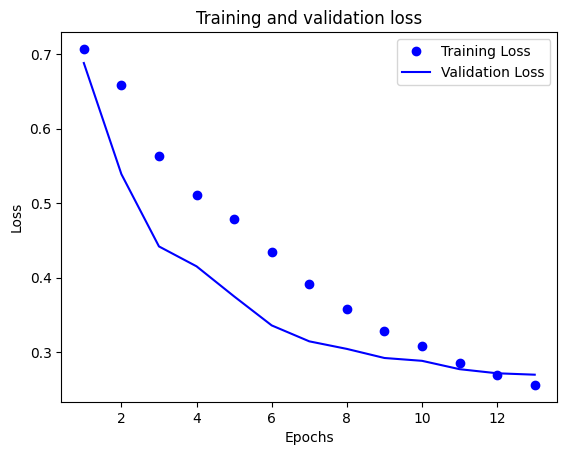

In [12]:
epochs = range(1, len(history['loss'])+1)
plt.plot(epochs, history['loss'], 'bo', label='Training Loss')
plt.plot(epochs, history['val_loss'], 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Training and validation accuracy

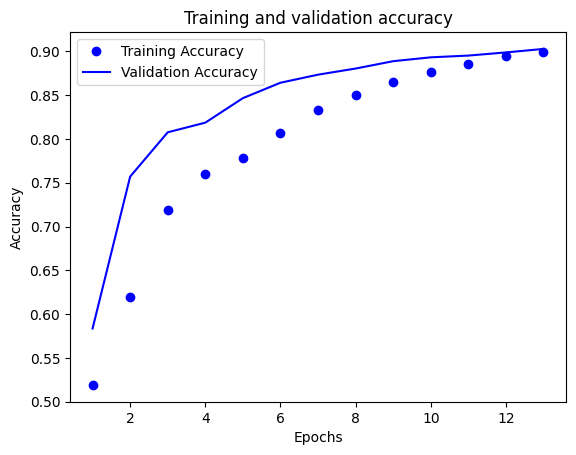

In [13]:
plt.plot(epochs, history['accuracy'], 'bo', label='Training Accuracy')
plt.plot(epochs, history['val_accuracy'], 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Test Accuracy

In [10]:
val_loss, val_accuracy = model.evaluate(x_val, y_val, verbose=0)
print(f"\nValidation accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")

# Оценка на тестовой выборке
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")


Validation accuracy: 0.9028 (90.28%)
Test accuracy: 0.8987 (89.87%)
